In [1]:
from copy import deepcopy
import tqdm.notebook

import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import (
    GaussianMixture,
    FunnelDistribution,
    Gaussian,
    BananaDistribution,
)
from adaptive_mcmc.samplers import (
    base_sampler,
    mala,
    fishermala,
    hmc,
    hmcadaptive,
)
from adaptive_mcmc.samplers.stopping_rule import NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils
from adaptive_mcmc.tools.metrics import compute_ess, compute_emd

from typing import Tuple, Optional

2025-05-24 13:24:15.306796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748082255.316462   22672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748082255.319225   22672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": {
        "common": mala.MALACommonParams(
            sigma=1e0,
            sigma_lr=1e-2,    
        ),
    },
    # "fisher_mala": {
    #     "common": fishermala.FisherMALACommonParams(
    #         dampening=100,
    #         sigma=1e0,
    #         sigma_lr=1e-2,
    #     ),
    # },
    "hmc_vanilla": {
        "common": hmc.HMCCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
        ),
        "fixed": hmc.HMCFixedParams(no_grad=True, stop_grad=False),
    },
    "taylor_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            learning_rate=3e-4,
            truncation_level_prob=0.5,
            min_truncation_level=2,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            penalty_weight_max=1e1,
            penalty_weight=1e-3,
            penalty_weight_adaptive_rate=1e-3,
            clip_grad_value=1e1,
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    "lanczos_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            learning_rate=3e-4,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            clip_grad_value=1e1,
            lanczos_steps=8,
            krylov_probe_vectors=1,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    # "hmcadaptive_hutch_taylor": {
    #     "common": hmcadaptive.HMCAdaptiveCommonParams(
    #         lf_step_count=25,
    #         lf_step_size=0.1,
    #         learning_rate=1e-3,
    #         truncation_level_prob=0.5,
    #         min_truncation_level=2,
    #         entropy_weight=1e-1,
    #         entropy_weight_min=1e-3,
    #         entropy_weight_max=1e2,
    #         penalty_weight_max=1e1,
    #         penalty_weight=1e-3,
    #         penalty_weight_adaptive_rate=1e-3,
    #         clip_grad_value=1e1,
    #     ),
    #     "fixed": hmcadaptive.HMCAdaptiveFixedParams(
    #         prec_init_scale=1e-1,
    #         no_grad=False,
    #         stop_grad=False,
    #         prec_type="tridiag",
    #         # iter_count=10000,
    #         # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    #     ),
    # },
    # "hmcadaptive_hutch_lanczos": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_noent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-4,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     entropy_method="none",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_fullent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     entropy_method="full",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
}

In [24]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float=5e-1,
    scale: float=5.,
):
    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    scales = torch.rand((gaussian_count, dimension)) * scale

    while True:
        try:
            true_covs = torch.rand((gaussian_count, dimension, dimension))
            true_covs, _ = torch.linalg.qr(true_covs)
        
            true_covs = (
                true_covs @ torch.diag_embed(scales) @ true_covs.permute(0, 2, 1) 
                + eps * torch.eye(dimension).unsqueeze(0)
            )
            
            # true_covs = (
            #     true_covs @ true_covs.permute(0, 2, 1) +
            #     torch.eye(dimension).repeat(gaussian_count, 1, 1)
            # )
        
            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
            )
            break
        except ValueError:
            pass
            
    return gm, true_means

In [25]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float = 5e-1,
    scale: float = 1.0,
    *,
    seed: Optional[int] = None,
    device: torch.device | str = "cpu",
    dtype: torch.dtype = torch.float32,
) -> Tuple[GaussianMixture, torch.Tensor]:
    """
    Create a reproducible random Gaussian Mixture.

    Parameters
    ----------
    gaussian_count : int      # number of components
    dimension      : int      # dimensionality
    cube           : float    # component means ∈ (-cube/2, cube/2)
    eps            : float    # ε·I added to each covariance
    scale          : float    # upper–bound on random eigen-scales
    seed           : int|None # RNG seed for reproducibility
    device         : str|torch.device
    dtype          : torch.dtype

    Returns
    -------
    gm          : GaussianMixture
    true_means  : Tensor (gaussian_count, dimension)
    """
    g = torch.Generator(device=device)
    if seed is not None:
        g.manual_seed(seed)

    true_means = (
        torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype)
        * cube - cube/2
    )

    scales = torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype) * scale

    while True:
        try:
            # Q = torch.rand((gaussian_count, dimension, dimension), generator=g, device=device, dtype=dtype)
            # Q, _ = torch.linalg.qr(Q)
            Q_list = []
            for _ in range(gaussian_count):
                q = torch.randn((dimension, dimension), generator=g, device=device, dtype=dtype)
                q, _ = torch.linalg.qr(q)
                Q_list.append(q)
            
            Q = torch.stack(Q_list, dim=0)  # shape: (gaussian_count, dimension, dimension)


            true_covs = (
                Q @ torch.diag_embed(scales) @ Q.transpose(-1, -2)
                + eps * torch.eye(dimension, device=device, dtype=dtype).unsqueeze(0)
            )

            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1.0 / gaussian_count, device=device, dtype=dtype),
            )
            break
        except ValueError:
            continue

    return gm, true_means

In [26]:
def generate_simplex(d: int) -> torch.Tensor:
    I = torch.eye(d)
    
    ones = torch.ones((d, d)) / (d+1)
    v1d = I - ones
    vdp1 = -torch.ones((1, d)) / (d+1)
    return torch.cat([v1d, vdp1], dim=0)


def get_toeplitz_GM(dimension: int, cube: float, rho: float=0.99, sigma: float=1.):
    true_means = generate_simplex(dimension) * cube

    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))

    true_covs = sigma ** 2 * rho ** power
    true_covs = true_covs.repeat(dimension + 1, 1, 1)

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.ones(dimension + 1) / (dimension + 1)
    )

    return gm, true_means


def get_toeplitz_gaussian(dimension: int,
                          mean: float = None,
                          rho: float = 0.99,
                          sigma: float = 1.0) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))
    cov = (sigma ** 2) * (rho ** power)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)


def get_illcond_gaussian(dimension: int,
                         mean: float = None,
                         min_v: float = 1e-2,
                         max_v: float = 1e2) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
    elif isinstance(mean, (float, int)):
        mean = torch.full((dimension,), float(mean))
    else:
        mean = torch.tensor(mean, dtype=torch.float32)

    # Create log-spaced eigenvalues (ill-conditioned spectrum)
    eigvals = torch.logspace(torch.log10(torch.tensor(min_v)), 
                             torch.log10(torch.tensor(max_v)), 
                             steps=dimension)

    # Construct diagonal covariance matrix
    cov = torch.diag(eigvals)

    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)
    

def sample_se_covariance_torch(dimension, scale=4., noise=0.01, seed=None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)

    x = torch.linspace(0, scale, dimension)

    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    dist_squared = (x1 - x2) ** 2

    K = torch.exp(-0.5 * dist_squared / (0.1 * scale**2))

    K += noise * torch.eye(dimension, device=device)

    return x, K
    
def get_deterministic_gaussian_se(dimension: int,
                                  mean: float = None,) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    _, cov = sample_se_covariance_torch(dimension)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)

def get_banana(dimension: int, b: float = 2.):
    mean = torch.zeros(dimension)
    return BananaDistribution(dimension, b), mean.unsqueeze(0)

In [50]:
# dist = FunnelDistribution(32, scale=3)

#dist, _ = get_toeplitz_gaussian(256, rho=0.95)
# dist, _ = get_deterministic_gaussian_se(32)
#dist, _ = get_illcond_gaussian(128)
dist, _ = get_banana(32, b=20.)

# dist, _ = get_random_GM(gaussian_count=25, dimension=32, cube=2., scale=2.,)
# dist, _ = get_toeplitz_GM(dimension=32, cube=2., rho=0.9)


samples = dist.sample(5000).detach().numpy()

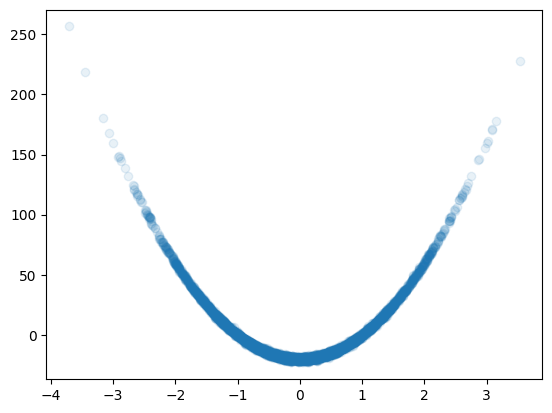

In [51]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

In [53]:
def dist_factory(name, dimension, cube=2., scale=2., funnel_scale=3, gaussian_count=25, rho=0.95, sigma=1.,
                 min_v=1e-3, max_v=1e3, bending=20.
                ):
    if name == "random_gm":
        return get_random_GM(gaussian_count=gaussian_count, dimension=dimension, cube=cube, scale=scale)
    elif name == "toeplitz_gm":
        return get_toeplitz_GM(dimension, cube=cube, rho=rho, sigma=sigma)
    elif name == "toeplitz_gaussian":
        return get_toeplitz_gaussian(dimension, rho=rho, sigma=sigma)
    elif name == "deterministic_gaussian_se":
        return get_deterministic_gaussian_se(dimension)
    elif name == "funnel":
        return FunnelDistribution(dimension, scale=funnel_scale), torch.zeros(1, dimension)
    elif name == "illcond_gaussian":
        return get_illcond_gaussian(dimension, min_v=min_v, max_v=max_v)
    elif name == "banana":
        return get_banana(dimension, b=bending)

In [54]:
import pandas as pd
from scipy.stats import norm
from itertools import combinations


def drop_static_chains(samples: torch.Tensor, eps: float = 0.0):
    var_per_chain = samples.var(dim=0, unbiased=False)

    static = (var_per_chain <= eps).all(dim=-1)
    keep_mask = ~static

    return samples[:, keep_mask, :], keep_mask.sum().item()


def z_test(dim_stat):
    all_results = {}
    for dim, df in dim_stat.items():
        recs = []
        algs = df.columns
        for A, B in combinations(reversed(algs), 2):
    
            mA, sA = df.loc['ess_mean', A], df.loc['ess_conf_sigma', A]
            mB, sB = df.loc['ess_mean', B], df.loc['ess_conf_sigma', B]
            z_ess = (mA - mB) / (sA**2 + sB**2)**0.5
            p_ess = norm.sf(z_ess)
    
            tA, seA = df.loc['tv_mean', A], df.loc['tv_conf_sigma', A]
            tB, seB = df.loc['tv_mean', B], df.loc['tv_conf_sigma', B]
            z_tv = (tB - tA) / (seA**2 + seB**2)**0.5
            p_tv = norm.sf(z_tv)
            recs.append({
                'alg_A': A, 'alg_B': B,
                'z(ESS_A>B)': z_ess, 'p(ESS_A>B)': p_ess,
                'z(TV_A<B)': z_tv,  'p(TV_A<B)': p_tv,
            })
        all_results[dim] = pd.DataFrame.from_records(recs)
    return all_results


def compute_results(hist_data, algs, dist_name=None):
    dim_stat = {}

    for dimension in tqdm.notebook.tqdm(dimensions, desc="dimension"):
        rows = []
        for alg in tqdm.notebook.tqdm(algs, desc="alg", leave=False):
            obj = hist_data[dimension][alg]
            cache = obj["cache"]
            pure_runtime = obj["pure_runtime"]
    
            clean_samples, n_kept = drop_static_chains(cache.samples)
    
            metrics = BenchmarkUtils.compute_metrics(clean_samples,
                                                     cache.true_samples)
            metrics["runtime"]      = pure_runtime
            metrics["chains_kept"]  = n_kept
            rows.append(metrics)
    
        df = pd.DataFrame(rows, index=list(algs.keys())).T
        dim_stat[dimension] = df
        print(f"\ndim={dimension}, dist={dist_name}\n", df)
        print(z_test(dim_stat))
    
    return dim_stat

In [55]:
def run_experiment(dist_name, log=[]):
    hist_data = {}
    loge = {
        "hist_data": hist_data,
        "algs": algs,
        "dist_name": dist_name,
        "dim_stat": None,
    }
    log.append(loge)
    runtime = {
        dimension: dict()
        for dimension in dimensions
    }
    pure_runtime = deepcopy(runtime)
    distance_to_mass_points = 1.
    
    for dimension in tqdm.notebook.tqdm(dimensions):
        print("Processing dimension", dimension)
        hist_data[dimension] = {}
        target_dist, true_means = dist_factory(dist_name, dimension)
        
        # target_dist, true_means = get_random_GM(gaussian_count, dimension, cube)
        # gm, true_means = get_deterministic_GM(dimension, cube)
        # true_samples = gm.sample(sample_count)
    
        # target_dist = FunnelDistribution(dimension, scale=scale)
        
        # target_dist, _ = get_deterministic_gaussian(dimension, rho=0.8)
        # target_dist, _ = get_deterministic_gaussian_se(dimension)
    
        # true_means = torch.zeros(1, dimension)
        true_samples = target_dist.sample(sample_count)
        
        starting_points = BenchmarkUtils.generate_starting_points(
            chain_count, dimension,
            true_means,
            distance_to_mass_points,
        )
    
        common_params = base_sampler.CommonParams(
            target_dist=target_dist,
            starting_point=starting_points.clone(),
            proposal_dist=torch.distributions.MultivariateNormal(
                torch.zeros(dimension, device=device),
                torch.eye(dimension, device=device),
            ),
        )
    
        for alg in algs:
            print("-" * 80)
            base_meta_adj = hparams[alg]["common"].copy_update(common_params)
            # if hasattr(base_meta_adj, "sigma"):
            #     base_meta_adj.sigma /= dimension
    
            algs[alg].load_params(base_meta_adj)
            algs[alg].load_true_samples(true_samples)
            algs[alg].run()
    
            loge["hist_data"][dimension][alg] = {
                "cache": algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                "stop_data_hist": algs[alg].pipeline.sample_blocks[-1].stop_data_hist,
                "runtime": algs[alg].pipeline.runtime,
                "pure_runtime": algs[alg].pipeline.pure_runtime,
            }
        print()
    
    dim_stat = compute_results(hist_data, algs, dist_name)
    loge["dim_stat"] = dim_stat

In [56]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

def print_log(log):
    for entry in log:
        for dimension in dimensions:
            print(f"\ndim={dimension}, dist={entry['dist_name']}\n", entry["dim_stat"][dimension])

In [57]:
chain_count = 30
sample_count = 5000
sample_iter_limit = 5000
burn_in_iter_count = 5000
step_size_burn_in_iter_count = 2500
probe_period = 250000

tv_threshold = 0.05
tail_count_cap = 1000
# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(
    density_probe_count=500,
    projection_count=25,
    tail_count_cap=tail_count_cap,
)


dist_names = [
    # "toeplitz_gm",
    # "toeplitz_gaussian",
    #"funnel",
    #"random_gm",
    #"illcond_gaussian",
    "banana",
]

dimensions = [8, 16, 32, 64, 128, 256]
log = []

for dist_name in dist_names:
    algs = {
        "mala": mala.MALAVanilla(
            pipeline=None,
            name="MALA",
            sigma_burn_in_params=hparams["mala"]["common"].copy(),
            sigma_burn_in_iter_count=burn_in_iter_count + step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
        ),
        # "fisher_mala": fishermala.FisherMALAVanilla(
        #     pipeline=None,
        #     name="FisherMALA",
        #     sigma_burn_in_iter_count=step_size_burn_in_iter_count,
        #     #common_params=hparams["fisher_mala"]["common"].copy(),
        #     #fixed_params=hparams["fisher_mala"]["fixed"],
        #     prec_burn_in_iter_count=burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        "hmc_vanilla": hmc.HMCVanilla(
            pipeline=None,
            name="HMCVanilla",
            common_params=hparams["hmc_vanilla"]["common"].copy(),
            fixed_params=hparams["hmc_vanilla"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[False, False, False],
        ),
        "taylor_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchTaylorNoGrad",
            common_params=hparams["taylor_nograd"]["common"].copy(),
            fixed_params=hparams["taylor_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[False, False, False],
        ),
        "lanczos_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchLanczosNoGrad",
            common_params=hparams["lanczos_nograd"]["common"].copy(),
            fixed_params=hparams["lanczos_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[False, False, False],
        ),
        # "hmcadaptive_hutch_taylor": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveHutchTaylor",
        #     common_params=hparams["hmcadaptive_hutch_taylor"]["common"].copy(),
        #     fixed_params=hparams["hmcadaptive_hutch_taylor"]["fixed"],
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_fullent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveFullEnt",
        #     params=hparams["hmcadaptive_fullent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_noent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveNoEnt",
        #     params=hparams["hmcadaptive_noent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
    }
    run_experiment(dist_name, log=log)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.047050707042217255
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.047380056232213974
Runtime: 6.18s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.027960412204265594
max_step_size=0.4448672831058502
broken_traj=216
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02563091181218624
max_step_size=0.43734052777290344
broken_traj=268
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.023757852613925934
max_step_size=0.4310494065284729
broken_traj=314
Runtime: 144.15s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.028118321672081947
max_step_size=0.3712572455406189
broken_traj=382
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0272831991314888
max_step_size=0.36935505270957947
broken_traj=399
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0272831991314888
max_step_size=0.36935505270957947
broken_traj=399
Runtime: 234.60s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.026804940775036812
max_step_size=0.3916153013706207
broken_traj=374
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.024885116145014763
max_step_size=0.3857763111591339
broken_traj=417
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.021397734060883522
max_step_size=0.3743665814399719
broken_traj=509
Runtime: 252.52s

Processing dimension 16
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.049001049250364304
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.050910837948322296
Runtime: 6.25s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02791837602853775
max_step_size=0.4458926320075989
broken_traj=222
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.024935245513916016
max_step_size=0.43534374237060547
broken_traj=290
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02346254512667656
max_step_size=0.43043678998947144
broken_traj=327
Runtime: 141.85s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.028785530477762222
max_step_size=0.41014179587364197
broken_traj=327
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02829792909324169
max_step_size=0.40871283411979675
broken_traj=337
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02829792909324169
max_step_size=0.40871283411979675
broken_traj=337
Runtime: 230.21s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02656393125653267
max_step_size=0.4020597040653229
broken_traj=367
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.024715391919016838
max_step_size=0.39587217569351196
broken_traj=410
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.021857623010873795
max_step_size=0.3864644169807434
broken_traj=483
Runtime: 252.28s

Processing dimension 32
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.05646902322769165
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05680309981107712
Runtime: 6.42s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02732505090534687
max_step_size=0.44161370396614075
broken_traj=251
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02447623386979103
max_step_size=0.43181684613227844
broken_traj=315
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02299463003873825
max_step_size=0.4267740249633789
broken_traj=351
Runtime: 155.09s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.027844034135341644
max_step_size=0.3944697678089142
broken_traj=355
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.027844034135341644
max_step_size=0.3944697678089142
broken_traj=355
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.027844034135341644
max_step_size=0.3944697678089142
broken_traj=355
Runtime: 241.56s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.0274895541369915
max_step_size=0.3959290087223053
broken_traj=371
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02601124718785286
max_step_size=0.3918476104736328
broken_traj=403
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.022525427863001823
max_step_size=0.38085708022117615
broken_traj=487
Runtime: 265.52s

Processing dimension 64
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.05244119092822075
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05749795585870743
Runtime: 6.99s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02790922485291958
max_step_size=0.44570446014404297
broken_traj=227
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.025946056470274925
max_step_size=0.4389694035053253
broken_traj=271
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.024447528645396233
max_step_size=0.4337761104106903
broken_traj=306
Runtime: 163.26s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.026738878339529037
max_step_size=0.38726553320884705
broken_traj=377
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.026368791237473488
max_step_size=0.3859741985797882
broken_traj=385
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.026368791237473488
max_step_size=0.3859741985797882
broken_traj=385
Runtime: 254.23s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02691141702234745
max_step_size=0.40614283084869385
broken_traj=371
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.025071604177355766
max_step_size=0.400838166475296
broken_traj=411
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02265021577477455
max_step_size=0.3925643265247345
broken_traj=471
Runtime: 278.14s

Processing dimension 128
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.053745925426483154
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05606668069958687
Runtime: 8.28s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02703387849032879
max_step_size=0.4498194456100464
broken_traj=254
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.024195699021220207
max_step_size=0.4399472773075104
broken_traj=319
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02271578088402748
max_step_size=0.4340038001537323
broken_traj=356
Runtime: 173.90s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.026806596666574478
max_step_size=0.3935442864894867
broken_traj=394
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02653495781123638
max_step_size=0.3921510577201843
broken_traj=400
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02653495781123638
max_step_size=0.3921510577201843
broken_traj=400
Runtime: 275.48s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02802448533475399
max_step_size=0.3816365897655487
broken_traj=337
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.026488034054636955
max_step_size=0.3771483600139618
broken_traj=371
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.023297015577554703
max_step_size=0.36796820163726807
broken_traj=447
Runtime: 302.31s

Processing dimension 256
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/7500 [00:00<?, ?it/s]

step_size=0.054486583918333054
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05892622098326683
Runtime: 13.61s
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.026911085471510887
max_step_size=0.42714399099349976
broken_traj=265
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.024162329733371735
max_step_size=0.4187701344490051
broken_traj=328
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.023413989692926407
max_step_size=0.41594794392585754
broken_traj=347
Runtime: 203.11s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.027713770046830177
max_step_size=0.39156264066696167
broken_traj=365
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02765984646975994
max_step_size=0.39156264066696167
broken_traj=366
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02765984646975994
max_step_size=0.39156264066696167
broken_traj=366
Runtime: 319.77s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.02778535522520542
max_step_size=0.4059410095214844
broken_traj=348
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.025408891960978508
max_step_size=0.3983868360519409
broken_traj=401
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.02241232432425022
max_step_size=0.38839492201805115
broken_traj=476
Runtime: 360.32s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=8, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.005268     0.431580       0.044416        0.248654
ess_conf_sigma   0.000241     0.019983       0.016449        0.035837
tv_mean          0.677873     0.197983       0.114253        0.115393
tv_conf_sigma    0.033998     0.027644       0.010737        0.011446
runtime          6.122550   143.580378     233.721359      251.628531
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    5.179513   1.112327e-07  -0.072647   
1  lanczos_nograd    hmc_vanilla   -4.458157   9.999959e-01   2.760421   
2  lanczos_nograd           mala    6.791294   5.556598e-12  15.679917   
3   taylor_nograd    hmc_vanilla  -14.958573   1.000000e+00   2.823433   
4   taylor_nograd           mala    2.379635   8.664907e-03  15.808572   
5     hmc_vanilla           mala   21.332

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=16, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.004493     0.464143       0.048603        0.302528
ess_conf_sigma   0.000082     0.026516       0.013659        0.049927
tv_mean          0.559833     0.230292       0.109793        0.118043
tv_conf_sigma    0.041463     0.030566       0.010434        0.012094
runtime          6.203499   141.353325     229.398905      251.405077
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    5.179513   1.112327e-07  -0.072647   
1  lanczos_nograd    hmc_vanilla   -4.458157   9.999959e-01   2.760421   
2  lanczos_nograd           mala    6.791294   5.556598e-12  15.679917   
3   taylor_nograd    hmc_vanilla  -14.958573   1.000000e+00   2.823433   
4   taylor_nograd           mala    2.379635   8.664907e-03  15.808572   
5     hmc_vanilla           mala   21.33

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=32, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.004447     0.470536       0.083102        0.344824
ess_conf_sigma   0.000133     0.022383       0.022877        0.051518
tv_mean          0.409721     0.182151       0.113818        0.110237
tv_conf_sigma    0.033925     0.026831       0.011182        0.015674
runtime          6.371686   154.551388     240.720530      264.633543
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    5.179513   1.112327e-07  -0.072647   
1  lanczos_nograd    hmc_vanilla   -4.458157   9.999959e-01   2.760421   
2  lanczos_nograd           mala    6.791294   5.556598e-12  15.679917   
3   taylor_nograd    hmc_vanilla  -14.958573   1.000000e+00   2.823433   
4   taylor_nograd           mala    2.379635   8.664907e-03  15.808572   
5     hmc_vanilla           mala   21.33

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=64, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.004252     0.573270       0.087089        0.386570
ess_conf_sigma   0.000057     0.032003       0.028109        0.058658
tv_mean          0.365957     0.159973       0.132018        0.075786
tv_conf_sigma    0.034570     0.029452       0.026659        0.010539
runtime          6.937300   162.681330     253.361892      277.174108
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    5.179513   1.112327e-07  -0.072647   
1  lanczos_nograd    hmc_vanilla   -4.458157   9.999959e-01   2.760421   
2  lanczos_nograd           mala    6.791294   5.556598e-12  15.679917   
3   taylor_nograd    hmc_vanilla  -14.958573   1.000000e+00   2.823433   
4   taylor_nograd           mala    2.379635   8.664907e-03  15.808572   
5     hmc_vanilla           mala   21.33

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=128, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.004244     0.485476       0.128053        0.327592
ess_conf_sigma   0.000071     0.026392       0.029929        0.055594
tv_mean          0.271117     0.168588       0.099895        0.063138
tv_conf_sigma    0.021557     0.027571       0.011427        0.008750
runtime          8.214790   173.286290     274.588235      301.189473
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    5.179513   1.112327e-07  -0.072647   
1  lanczos_nograd    hmc_vanilla   -4.458157   9.999959e-01   2.760421   
2  lanczos_nograd           mala    6.791294   5.556598e-12  15.679917   
3   taylor_nograd    hmc_vanilla  -14.958573   1.000000e+00   2.823433   
4   taylor_nograd           mala    2.379635   8.664907e-03  15.808572   
5     hmc_vanilla           mala   21.3

alg:   0%|          | 0/4 [00:00<?, ?it/s]


dim=256, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.004208     0.513659       0.104553        0.451180
ess_conf_sigma   0.000087     0.027686       0.028295        0.057346
tv_mean          0.261507     0.120971       0.141045        0.063291
tv_conf_sigma    0.021140     0.026717       0.024067        0.009248
runtime         13.520029   202.359963     318.616960      359.032927
chains_kept     30.000000    30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    5.179513   1.112327e-07  -0.072647   
1  lanczos_nograd    hmc_vanilla   -4.458157   9.999959e-01   2.760421   
2  lanczos_nograd           mala    6.791294   5.556598e-12  15.679917   
3   taylor_nograd    hmc_vanilla  -14.958573   1.000000e+00   2.823433   
4   taylor_nograd           mala    2.379635   8.664907e-03  15.808572   
5     hmc_vanilla           mala   21.3

In [13]:
import cloudpickle

In [14]:
# with open("exp_3.pkl", "wb") as f:
#     cloudpickle.dump(log, f)

Text(0.5, 1.0, 'taylor_nograd')

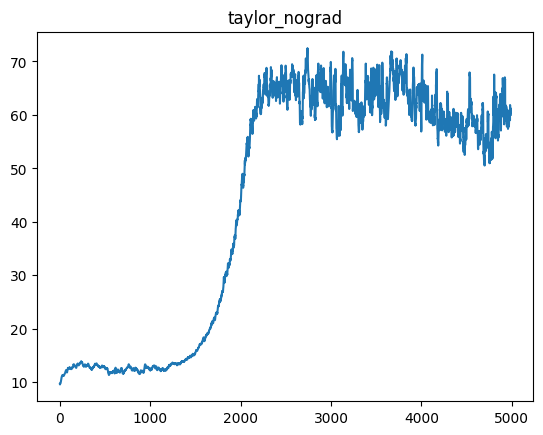

In [15]:
plt.plot(
    moving_average(
        algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("taylor_nograd")

Text(0.5, 1.0, 'lanczos_nograd')

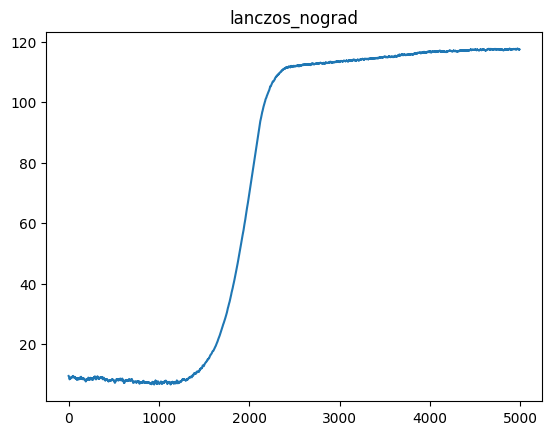

In [16]:
plt.plot(
    moving_average(
        algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("lanczos_nograd")

In [58]:
print_log(log)


dim=8, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.005268     0.431580       0.044416        0.248654
ess_conf_sigma   0.000241     0.019983       0.016449        0.035837
tv_mean          0.677873     0.197983       0.114253        0.115393
tv_conf_sigma    0.033998     0.027644       0.010737        0.011446
runtime          6.122550   143.580378     233.721359      251.628531
chains_kept     30.000000    30.000000      30.000000       30.000000

dim=16, dist=banana
                      mala  hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         0.004493     0.464143       0.048603        0.302528
ess_conf_sigma   0.000082     0.026516       0.013659        0.049927
tv_mean          0.559833     0.230292       0.109793        0.118043
tv_conf_sigma    0.041463     0.030566       0.010434        0.012094
runtime          6.203499   141.353325     229.398905      251.405077
chains_kept     30.000000    30.000000      30.

In [20]:
plt.plot(log[0]["hist_data"][dimension][alg]["cache"].grad_norm)

NameError: name 'dimension' is not defined

In [ ]:

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


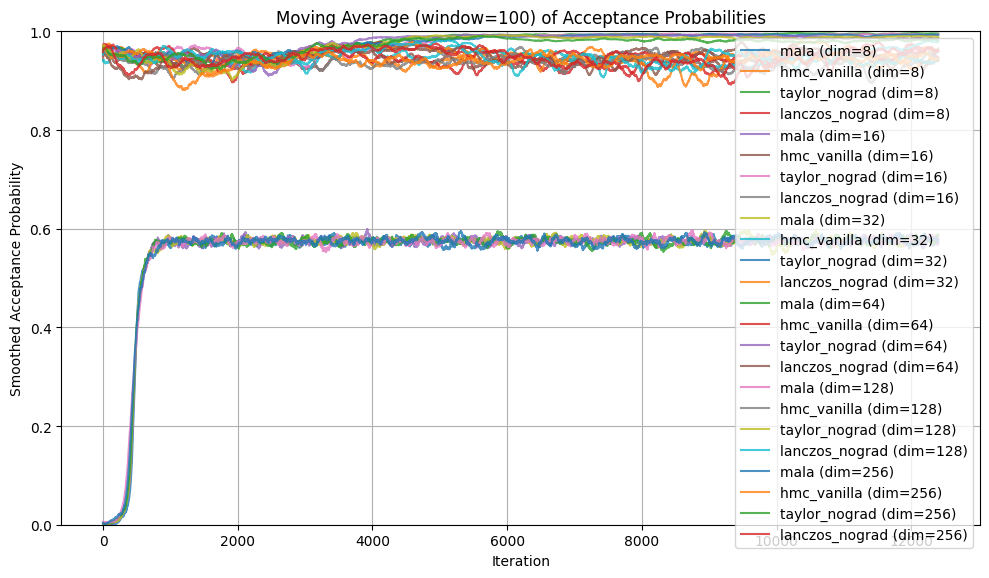

In [65]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.params.lf_step_size

In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1]

In [ ]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    log[0]["hist_data"][4]["fisher_mala"]["cache"].samples[:, :, :],
    log[0]["hist_data"][4]["fisher_mala"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["mala"]["cache"].samples[:, [2], :],
    log[0]["hist_data"][256]["mala"]["cache"].true_samples,
)

                              HMC


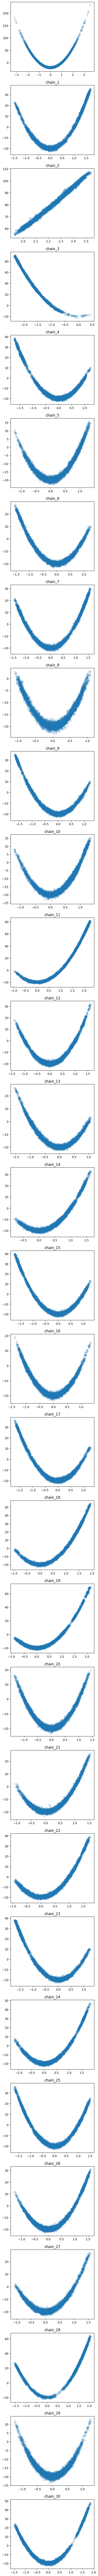

In [62]:
print(f"{' ' * 30}HMC")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["hmc_vanilla"]["cache"].samples[:, :, :],
    log[0]["hist_data"][256]["hmc_vanilla"]["cache"].true_samples,
)

                              HMC Taylor


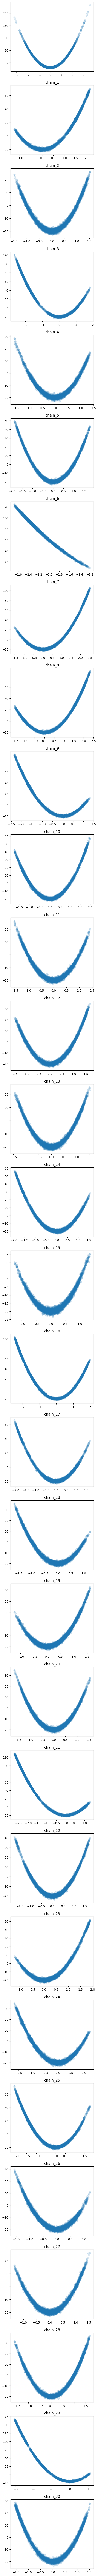

In [63]:
print(f"{' ' * 30}HMC Taylor")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["taylor_nograd"]["cache"].samples[:, :, :],
    log[0]["hist_data"][256]["taylor_nograd"]["cache"].true_samples,
)

                              HMC Lanczos


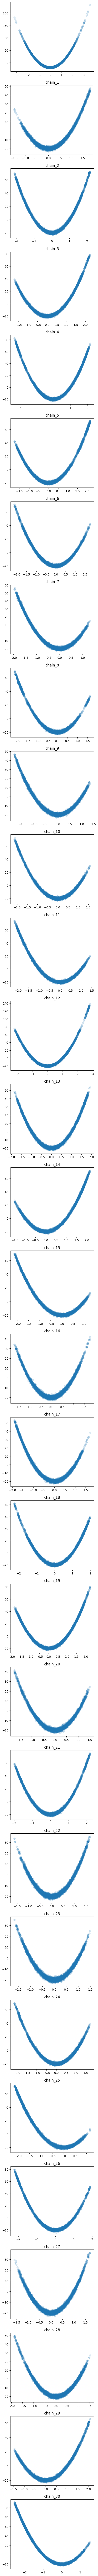

In [64]:
print(f"{' ' * 30}HMC Lanczos")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["lanczos_nograd"]["cache"].samples[:, :, :],
    log[0]["hist_data"][256]["lanczos_nograd"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.cache.samples[:, [2], :],
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [1], :],
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.sigma_prec

In [ ]:
algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.params.penalty_weight.squeeze()

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.prec[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[1].iteration.params.lf_step_size

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.params.lf_step_size

In [ ]:
minv

In [ ]:
prec = algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
diff = minv - minv_l

In [ ]:
plt.hist(diff[range(len(diff)), range(len(diff))])

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.prec[19].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
minv

In [ ]:
prec = algs["hmcadaptive_noent"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)